#### Importação

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from missforest import MissForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.manifold import trustworthiness
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture


/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


A base de dados 'all_worst' pode ser gerada através do notebook 'extract_exams_24h'

In [2]:
all_worst = pd.read_csv("../data/worst/all_worst.csv")

In [3]:
def generate_data(df):
    features= df[['ALT', 'Albumine', 'Bilirubin', 'Bun', 'Chloride', 'Glucose',
       'Heart_rate', 'INR', 'Lactate', 'Oxygen_saturation', 'Respiratory_rate',
       'Temperature', 'WBC', 'Bicarbonate', 'Hemoglobin',
       'sofa_24hours', 'gcs_min','anchor_age', 'pao2fio2ratio_vent',
       'platelet_min']]
    categorical= df[['admission_type',
       'marital_status', 'race', 'gender']]
    
    # Z-score normalization para as features numéricas
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # One-hot encoding para as features categóricas
    encoder = OneHotEncoder(drop='first', sparse_output=False)  # 'drop=first' para evitar a dummy trap
    categorical_encoded = encoder.fit_transform(categorical)

    # Criar DataFrames para as features normalizadas e codificadas
    features_final = pd.DataFrame(features_scaled, columns=features.columns)
    categorical_final = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical.columns))

    # Concatenar as features numéricas e categóricas
    final_data = pd.concat([features_final, categorical_final], axis=1)

    # Exibir o DataFrame final
    final_data

    return final_data

In [15]:
def generate_metrics(df, name_prefix):
    # Lista de números de clusters para testar
    k_values = range(2, 11)  # Testando de 2 a 10 clusters

    # Armazenar os resultados
    results = {
        'k': [],
        'Silhouette Score': [],
        'Intra Cluster Distance': [],
        'Inter Cluster Distance': [],
        'Davies-Bouldin Index': []
    }

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(df)
        labels = kmeans.labels_
        
        # Calcular as métricas
        silhouette = silhouette_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)
        
        # Calcular distâncias intra e inter cluster
        intra_cluster_distances = []
        inter_cluster_distances = []
        
        for cluster in range(k):
            cluster_points = df[labels == cluster]
            if len(cluster_points) > 1:
                intra_cluster_distances.append(pairwise_distances(cluster_points).mean())
        
        intra_cluster_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else np.nan
        
        # Distância média entre clusters
        for i in range(k):
            for j in range(i + 1, k):
                cluster_i = df[labels == i]
                cluster_j = df[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    distance = pairwise_distances(cluster_i, cluster_j).mean()
                    inter_cluster_distances.append(distance)
                    
        inter_cluster_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else np.nan
        
        # Armazenar os resultados
        results['k'].append(k)
        results['Silhouette Score'].append(silhouette)
        results['Intra Cluster Distance'].append(intra_cluster_distance)
        results['Inter Cluster Distance'].append(inter_cluster_distance)
        results['Davies-Bouldin Index'].append(davies_bouldin)
    
    # Criar DataFrame com os resultados
    metrics_df = pd.DataFrame(results)
    metrics_df['Dataset'] = name_prefix
    
    # Plot do Silhouette Score
    plt.figure(figsize=(12, 6))
    plt.plot(results['k'], results['Silhouette Score'], 'o-', label='Silhouette Score', color='green')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score para Diferentes Valores de k - {name_prefix}')
    plt.legend()
    plt.show()
    
    return metrics_df

In [16]:
def generate_gmm_metrics(df, name_prefix):
    # Lista de números de clusters para testar
    k_values = range(2, 11)  # Testando de 2 a 10 clusters

    # Armazenar os resultados
    results = {
        'k': [],
        'Silhouette Score': [],
        'Intra Cluster Distance': [],
        'Inter Cluster Distance': [],
        'Davies-Bouldin Index': []
    }

    for k in k_values:
        gmm = GaussianMixture(n_components=k, random_state=42,covariance_type='spherical')
        gmm.fit(df)
        labels = gmm.predict(df)
        
        # Calcular as métricas
        silhouette = silhouette_score(df, labels)
        davies_bouldin = davies_bouldin_score(df, labels)
        
        # Calcular distâncias intra e inter cluster
        intra_cluster_distances = []
        inter_cluster_distances = []
        
        for cluster in range(k):
            cluster_points = df[labels == cluster]
            if len(cluster_points) > 1:
                intra_cluster_distances.append(pairwise_distances(cluster_points).mean())
        
        intra_cluster_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else np.nan
        
        # Distância média entre clusters
        for i in range(k):
            for j in range(i + 1, k):
                cluster_i = df[labels == i]
                cluster_j = df[labels == j]
                if len(cluster_i) > 0 and len(cluster_j) > 0:
                    distance = pairwise_distances(cluster_i, cluster_j).mean()
                    inter_cluster_distances.append(distance)
                    
        inter_cluster_distance = np.mean(inter_cluster_distances) if inter_cluster_distances else np.nan
        
        # Armazenar os resultados
        results['k'].append(k)
        results['Silhouette Score'].append(silhouette)
        results['Intra Cluster Distance'].append(intra_cluster_distance)
        results['Inter Cluster Distance'].append(inter_cluster_distance)
        results['Davies-Bouldin Index'].append(davies_bouldin)
    
    # Criar DataFrame com os resultados
    metrics_df = pd.DataFrame(results)
    metrics_df['Dataset'] = name_prefix
    
    # Plot do Silhouette Score
    plt.figure(figsize=(12, 6))
    plt.plot(results['k'], results['Silhouette Score'], 'o-', label='Silhouette Score', color='blue')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score para Diferentes Valores de k - {name_prefix}')
    plt.legend()
    plt.show()
    
    return metrics_df


#### Retirando colunas com mais de 80% nulo

In [52]:
null_percentage = all_worst.isnull().mean() * 100

# # Passo 2: Filtrar as colunas cuja porcentagem de nulos é inferior a 80%
columns_to_keep = null_percentage[null_percentage < 80].index

# Passo 3: Selecionar as colunas filtradas no DataFrame
all_worst = all_worst[columns_to_keep]


#### Reirando colunas similares

In [65]:
all_worst = all_worst[['ALT', 'AST', 'Albumine',
       'Bilirubin', 'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Sodium',
       'Temperature', 'WBC', 'Bicarbonate', 'Hemoglobin', 'sofa_24hours',
       'gcs_min', 'admission_type', 'marital_status', 'race', 'gender',
       'anchor_age', 'creatinine_max', 'pao2fio2ratio_vent', 'platelet_min'
       ]]

In [54]:
exams_columns = ['ALT', 'AST', 'Albumine',
       'Bilirubin', 'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Sodium',
       'Temperature', 'WBC', 'Bicarbonate', 'Hemoglobin', 'sofa_24hours',
       'gcs_min', 
       'creatinine_max', 'pao2fio2ratio_vent', 'platelet_min']

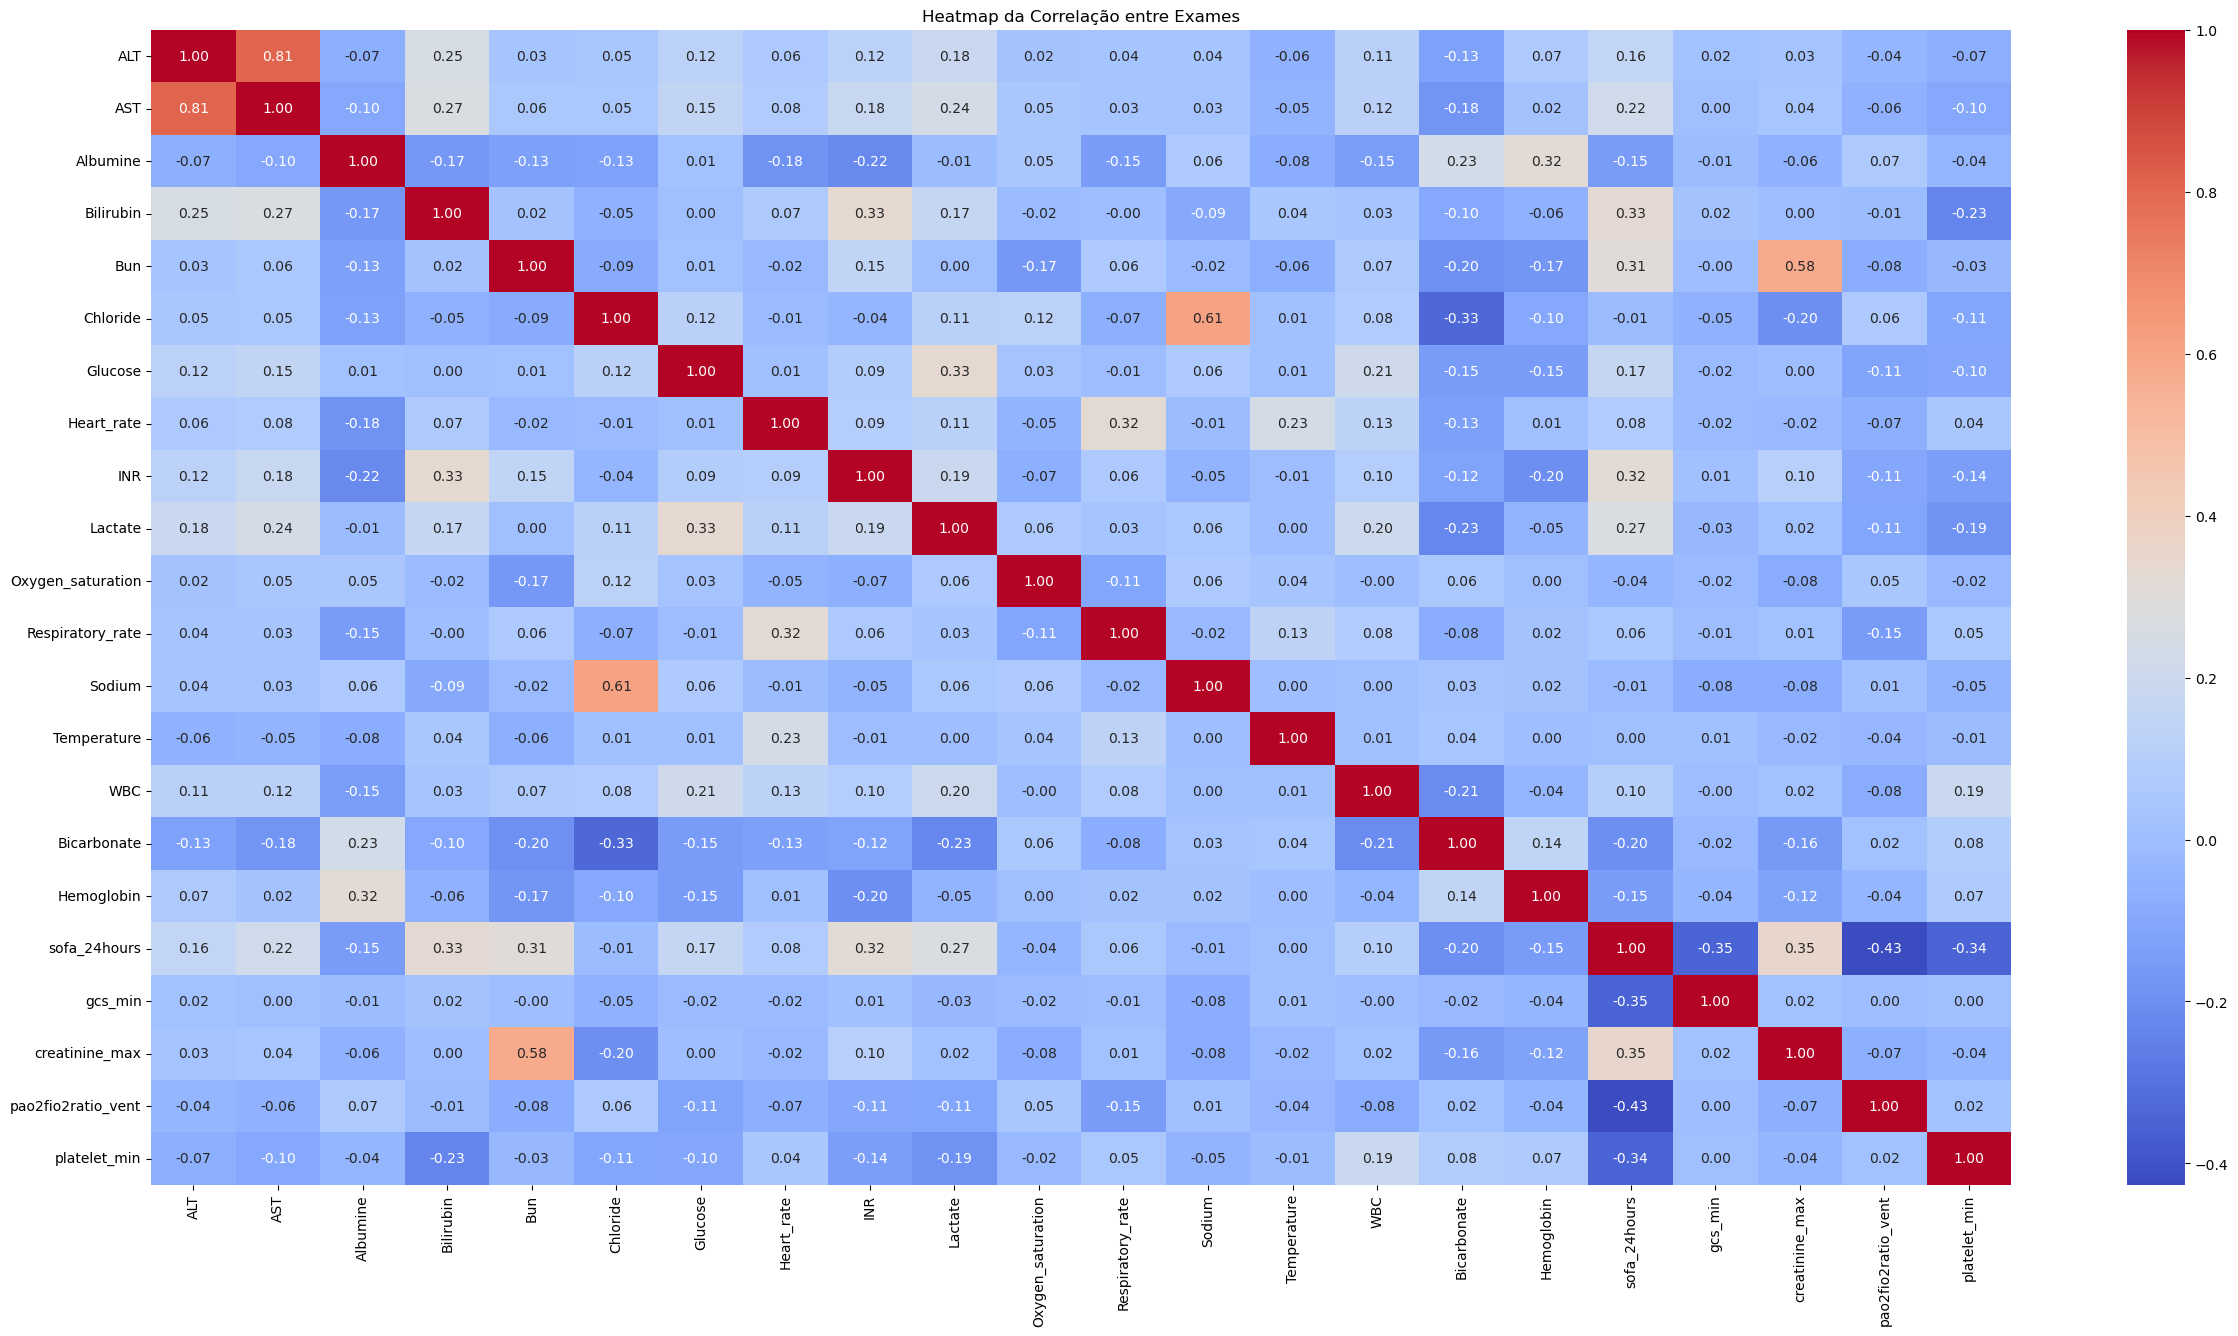

In [20]:
correlation_matrix = all_worst[exams_columns].corr()

# Configurando o tamanho da figura
plt.figure(figsize=(30, 15))

# Plotando o heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# Adicionando título
plt.title('Heatmap da Correlação entre Exames')

# Exibindo o gráfico
plt.show()

#### Retirando colunas com alta correlação

In [4]:
all_worst = all_worst[['ALT', 'Albumine', 'Bilirubin', 'Bun', 'Chloride', 'Glucose',
       'Heart_rate', 'INR', 'Lactate', 'Oxygen_saturation', 'Respiratory_rate',
       'Temperature', 'WBC', 'Bicarbonate', 'Hemoglobin',
       'sofa_24hours', 'gcs_min','anchor_age', 'pao2fio2ratio_vent',
       'platelet_min','admission_type',
       'marital_status', 'race', 'gender']]

#### Mapeando colunas categoricas

In [5]:
race_mapping = {
    'AMERICAN INDIAN/ALASKA NATIVE':'asian',
    'ASIAN':'asian',
    'ASIAN - ASIAN INDIAN': 'asian',
    'ASIAN - CHINESE': 'asian',
    'ASIAN - KOREAN': 'asian',
    'ASIAN - SOUTH EAST ASIAN': 'asian',
    'BLACK/AFRICAN': 'black',
    'BLACK/AFRICAN AMERICAN': 'black',
    'BLACK/CAPE VERDEAN': 'black',
    'BLACK/CARIBBEAN ISLAND': 'black',
    'HISPANIC OR LATINO': 'hispanic/latino',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'hispanic/latino',
    'HISPANIC/LATINO - COLUMBIAN': 'hispanic/latino',
    'HISPANIC/LATINO - CUBAN': 'hispanic/latino',
    'HISPANIC/LATINO - DOMINICAN': 'hispanic/latino',
    'HISPANIC/LATINO - GUATEMALAN': 'hispanic/latino',
    'HISPANIC/LATINO - HONDURAN': 'hispanic/latino',
    'HISPANIC/LATINO - MEXICAN': 'hispanic/latino',
    'HISPANIC/LATINO - PUERTO RICAN': 'hispanic/latino',
    'HISPANIC/LATINO - SALVADORAN': 'hispanic/latino',
    'MULTIPLE RACE/ETHNICITY': 'other',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'asian',
    'OTHER': 'other',
    'PATIENT DECLINED TO ANSWER': 'unknown',
    'PORTUGUESE': 'white',
    'SOUTH AMERICAN': 'hispanic/latino',
    'UNABLE TO OBTAIN': 'unknown',
    'UNKNOWN': 'unknown',
    'WHITE': 'white',
    'WHITE - BRAZILIAN': 'white',
    'WHITE - EASTERN EUROPEAN': 'white',
    'WHITE - OTHER EUROPEAN': 'white',
    'WHITE - RUSSIAN': 'white'
}

admission_map = {
    'EW EMER.': 'emergency',                 
    'URGENT': 'emergency',                           
    'OBSERVATION ADMIT': 'not emergency',               
    'SURGICAL SAME DAY ADMISSION': 'emergency',      
    'DIRECT EMER.': 'emergency',                     
    'ELECTIVE': 'not emergency',                        
    'EU OBSERVATION': 'not emergency',                    
    'DIRECT OBSERVATION': 'not emergency',                
    'AMBULATORY OBSERVATION': 'not emergency',             
}

# Mapeie as categorias na coluna 'race' para as novas categorias
all_worst['race'] = all_worst['race'].map(race_mapping)
all_worst['admission_type'] = all_worst['admission_type'].map(admission_map)

#### Imputação usando knn

In [15]:

# Separate columns to be imputed and columns to be excluded
columns_to_exclude = ['admission_type', 'marital_status', 'race', 'gender']
columns_to_impute = [col for col in all_worst.columns if col not in columns_to_exclude]

# Separate the data
data_to_impute = all_worst[columns_to_impute]
metadata = all_worst[columns_to_exclude]

# Initialize KNN Imputer
imputer = KNNImputer(n_neighbors=5)  # You can adjust the number of neighbors

# Fit and transform the data
imputed_data = imputer.fit_transform(data_to_impute)

# Create a DataFrame for the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)

# Recombine with the original metadata
worst_exams_24h_imputed_knn = pd.concat([metadata, imputed_df], axis=1)

worst_exams_24h_imputed_knn


,admission_type,marital_status,race,gender,ALT,Albumine,Bilirubin,Bun,Chloride,Glucose,...,Respiratory_rate,Temperature,WBC,Bicarbonate,Hemoglobin,sofa_24hours,gcs_min,anchor_age,pao2fio2ratio_vent,platelet_min
0,emergency,SINGLE,white,F,33.0,3.10,1.40,7.0,102.2,118.8,...,23.4,37.62,20.0,30.0,10.7,3.6,11.8,32.0,333.200000,253.4
1,not emergency,MARRIED,white,F,134.0,2.84,2.32,34.0,106.0,169.6,...,28.8,37.44,16.5,22.0,9.8,5.4,8.2,89.0,184.704762,278.0
2,not emergency,MARRIED,white,F,48.2,3.00,0.76,24.0,99.0,122.6,...,28.8,36.94,18.8,23.0,7.5,5.4,8.8,89.0,104.033333,297.4
3,not emergency,MARRIED,black,F,47.0,2.94,0.20,16.0,94.0,147.4,...,30.2,36.52,6.6,30.0,11.4,4.0,15.0,68.0,400.980645,149.0
4,emergency,SINGLE,other,F,33.0,2.84,2.08,16.0,109.0,216.0,...,23.0,37.70,20.2,23.0,10.2,4.0,15.0,53.0,180.000000,248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36576,emergency,SINGLE,white,M,35.0,2.80,3.10,21.0,103.0,174.0,...,19.0,36.78,6.8,19.0,10.8,8.0,15.0,56.0,185.500000,47.0
36577,not emergency,SINGLE,other,M,69.0,3.34,8.30,18.4,95.0,75.0,...,29.2,37.64,5.1,27.0,11.8,8.0,12.0,42.0,314.642857,33.0
36578,not emergency,DIVORCED,white,M,30.6,3.56,0.66,12.0,107.0,151.0,...,24.0,39.82,12.1,23.0,13.9,4.0,10.0,41.0,397.500000,121.0
36579,emergency,MARRIED,white,M,25.8,2.72,0.92,56.0,116.0,175.0,...,23.0,38.30,7.7,19.0,10.4,6.0,11.0,81.0,164.700000,127.0


#### Imputação usando missforest

In [6]:
columns_to_exclude = ['admission_type', 'marital_status', 'race', 'gender']
columns_to_impute = [col for col in all_worst.columns if col not in columns_to_exclude]

# Separate the data
data_to_impute = all_worst[columns_to_impute]
metadata = all_worst[columns_to_exclude]

# Initialize MissForest imputer
imputer = MissForest()

# Fit and transform the data
imputed_data = imputer.fit_transform(data_to_impute)

# Create a DataFrame for the imputed data
imputed_df = pd.DataFrame(imputed_data, columns=columns_to_impute)

# Recombine with the original metadata
worst_exams_24h_imputed_missforest = pd.concat([metadata, imputed_df], axis=1)

worst_exams_24h_imputed_missforest


100%|██████████| 5/5 [04:26<00:00, 53.34s/it] 


,admission_type,marital_status,race,gender,ALT,Albumine,Bilirubin,Bun,Chloride,Glucose,...,Respiratory_rate,Temperature,WBC,Bicarbonate,Hemoglobin,sofa_24hours,gcs_min,anchor_age,pao2fio2ratio_vent,platelet_min
0,emergency,SINGLE,white,F,33.000000,3.100000,1.400000,7.000000,99.194711,133.721398,...,26.693972,37.168307,20.0,30.0,10.7,4.662133,14.341066,32,204.598901,242.745103
1,not emergency,MARRIED,white,F,29.756833,3.154927,0.537644,34.000000,106.000000,148.604132,...,27.259211,37.089845,16.5,22.0,9.8,4.876674,13.534409,89,202.289394,200.480023
2,not emergency,MARRIED,white,F,26.200942,2.891659,0.419115,24.000000,99.000000,146.362664,...,31.100496,37.091234,18.8,23.0,7.5,4.402733,13.372356,89,205.781269,268.113214
3,not emergency,MARRIED,black,F,47.000000,3.545893,0.200000,16.000000,94.000000,166.816059,...,21.037982,36.626099,6.6,30.0,11.4,4.000000,15.000000,68,210.034312,149.000000
4,emergency,SINGLE,other,F,47.085613,3.283092,0.654700,16.000000,109.000000,216.000000,...,23.000000,37.700000,20.2,23.0,10.2,4.000000,15.000000,53,180.000000,248.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36576,emergency,SINGLE,white,M,35.000000,2.800000,2.116479,21.000000,103.000000,174.000000,...,19.000000,37.072503,6.8,19.0,10.8,8.000000,15.000000,56,241.742710,47.000000
36577,not emergency,SINGLE,other,M,69.000000,3.187899,8.300000,28.905045,95.000000,75.000000,...,23.500982,37.023302,5.1,27.0,11.8,8.000000,12.000000,42,282.319581,33.000000
36578,not emergency,DIVORCED,white,M,81.163568,3.558312,1.207249,12.000000,107.000000,151.000000,...,24.000000,37.240557,12.1,23.0,13.9,4.000000,10.000000,41,397.500000,121.000000
36579,emergency,MARRIED,white,M,37.430118,2.939133,0.450221,56.000000,116.000000,175.000000,...,23.000000,38.300000,7.7,19.0,10.4,6.000000,11.000000,81,242.157274,127.000000


#### Salvando bases

In [12]:
# worst_exams_24h_imputed_knn.to_csv("worst_exams_24h_imputed_knn.csv",index=False)
# worst_exams_24h_imputed_missforest.to_csv("worst_exams_24h_imputed_missforest.csv",index=False)
# all_worst.to_csv("all_worst_not_imputed.csv",index=False)

#### Reduzindo dimensionalidade

##### UMAP

In [8]:
final_data_missforest = generate_data(worst_exams_24h_imputed_missforest)
final_data_knn = generate_data(worst_exams_24h_imputed_knn)

/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3

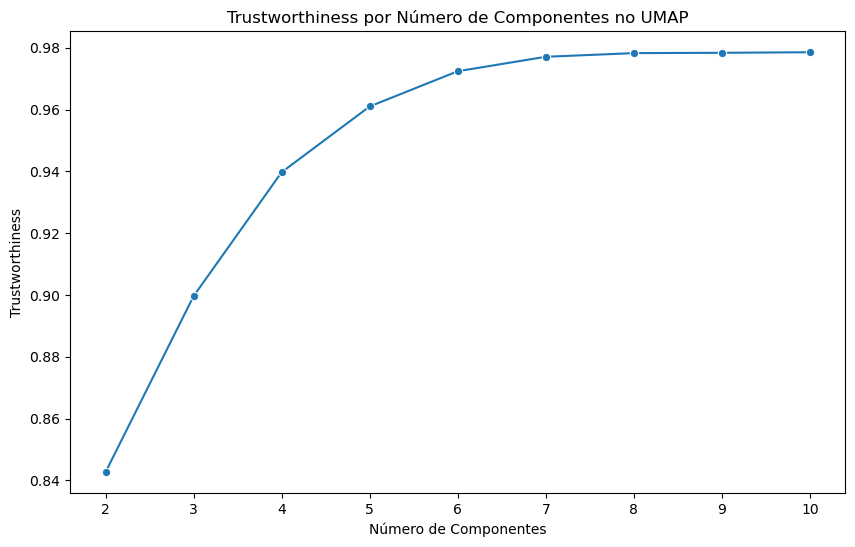

In [9]:
# Intervalo de componentes
n_components_range = range(2, 11)
trustworthiness_scores = []

# Calcular o trustworthiness para cada número de componentes
for n_components in n_components_range:
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    reduced_data = reducer.fit_transform(final_data_missforest)
    trust = trustworthiness(final_data_missforest, reduced_data)
    trustworthiness_scores.append(trust)

# Plotar os resultados
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_components_range), y=trustworthiness_scores, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Trustworthiness')
plt.title('Trustworthiness por Número de Componentes no UMAP')
plt.show()


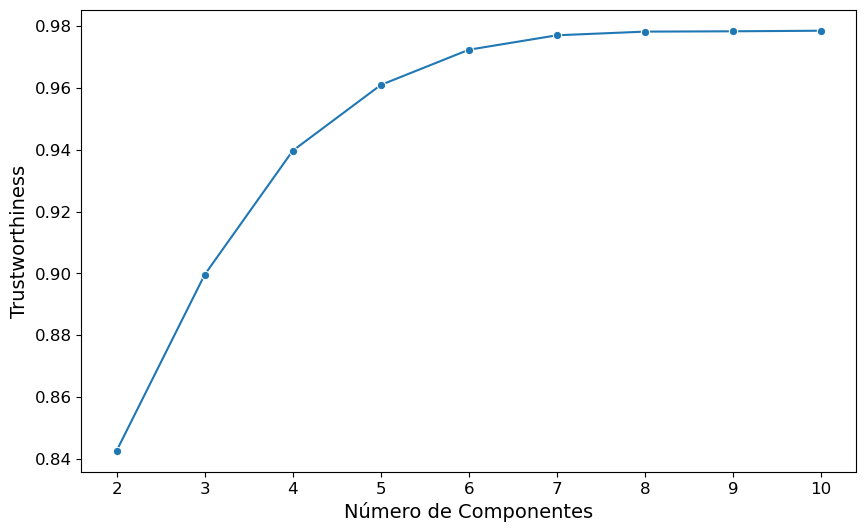

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_components_range), y=trustworthiness_scores, marker='o')
plt.xlabel('Número de Componentes', fontsize=14)
plt.ylabel('Trustworthiness', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3

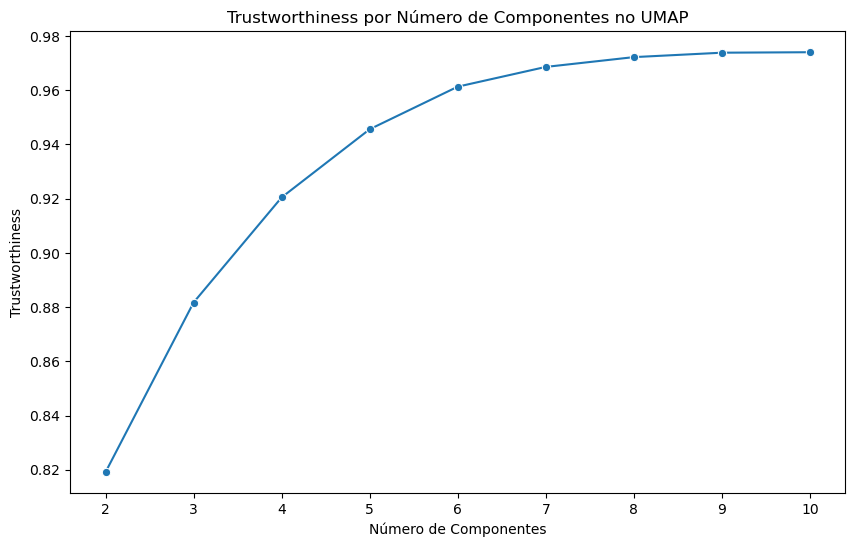

In [23]:
# Intervalo de componentes
n_components_range = range(2, 11)
trustworthiness_scores = []

# Calcular o trustworthiness para cada número de componentes
for n_components in n_components_range:
    reducer = umap.UMAP(n_components=n_components, random_state=42)
    reduced_data = reducer.fit_transform(final_data_knn)
    trust = trustworthiness(final_data_knn, reduced_data)
    trustworthiness_scores.append(trust)

# Plotar os resultados
plt.figure(figsize=(10, 6))
sns.lineplot(x=list(n_components_range), y=trustworthiness_scores, marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Trustworthiness')
plt.title('Trustworthiness por Número de Componentes no UMAP')
plt.show()

In [26]:
reducer = umap.UMAP(n_components=6, random_state=42)
final_data_missforest_umap = reducer.fit_transform(final_data_missforest)

reducer = umap.UMAP(n_components=7, random_state=42)
final_data_knn_umap = reducer.fit_transform(final_data_knn)


/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


##### T-SNE

In [27]:
reducer = TSNE(n_components=3, random_state=42)
final_data_missforest_tsne = reducer.fit_transform(final_data_missforest)

reducer = TSNE(n_components=3, random_state=42)
final_data_knn_tsne = reducer.fit_transform(final_data_knn)

#### Salvando

In [33]:
def save(final_data,name):
    reduced_df = pd.DataFrame(final_data, columns=[f'Component_{i+1}' for i in range(final_data.shape[1])])
    file_name = f"{name}.csv"
    reduced_df.to_csv(file_name, index=False)
    return reduced_df

In [ ]:
# save(final_data_missforest_tsne, "final_data_missforest_tsne")
# save(final_data_knn_tsne,"final_data_knn_tsne")
# save(final_data_missforest_umap, "final_data_missforest_umap")
# save(final_data_knn_umap, "final_data_knn_umap")

#### K-means

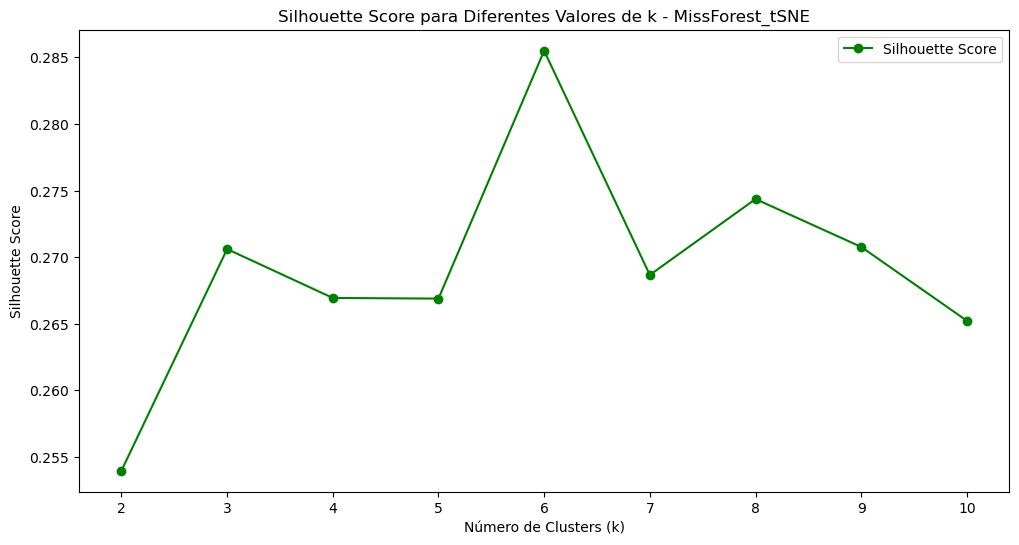

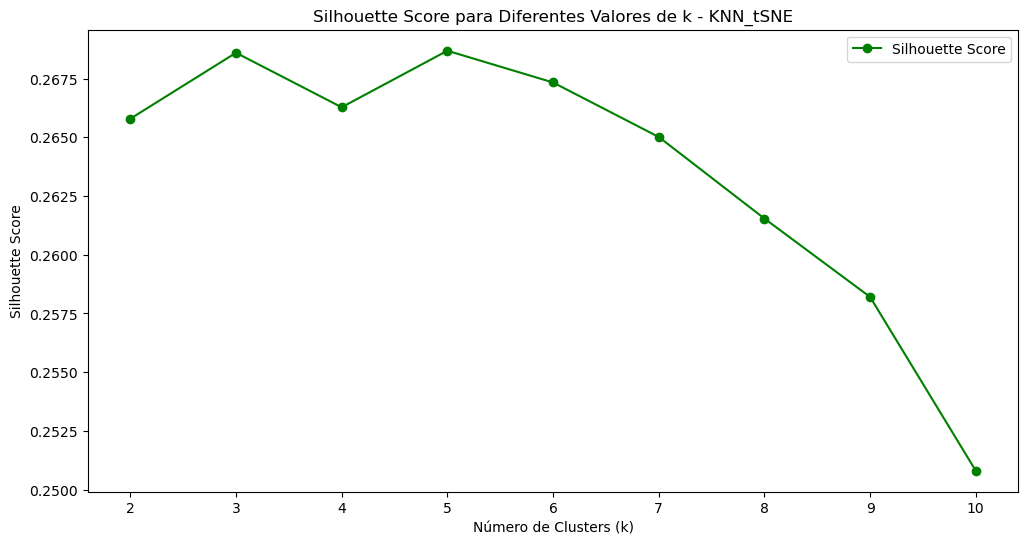

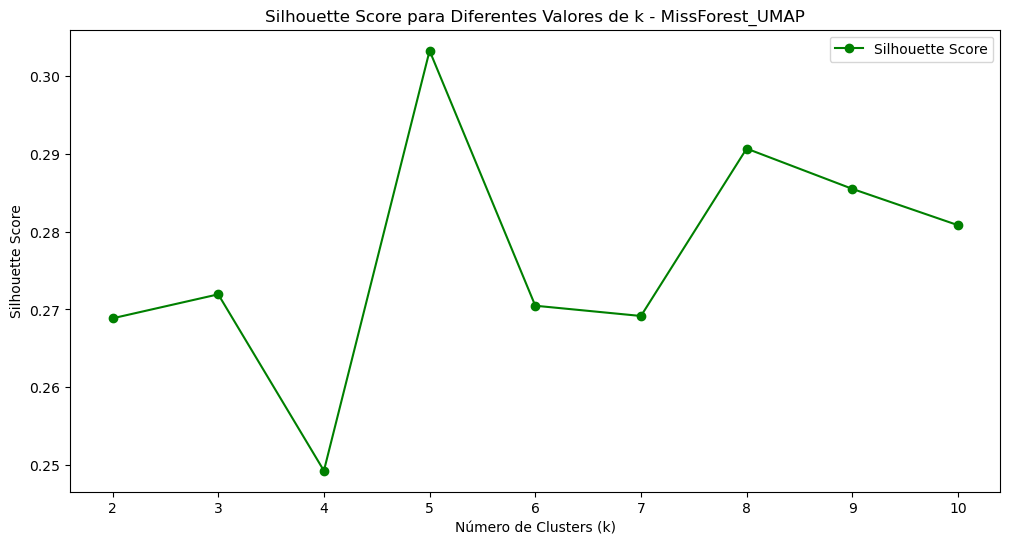

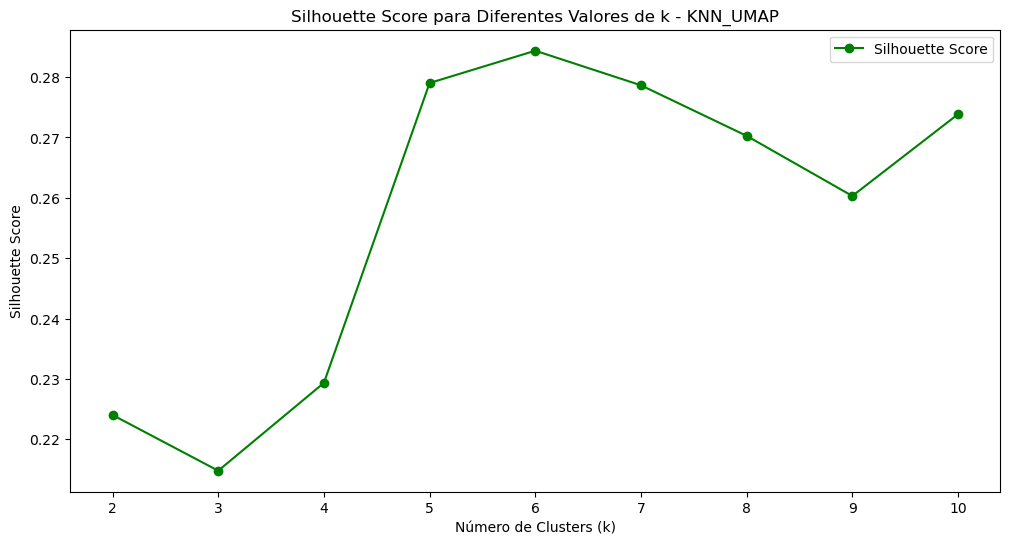

,k,Silhouette Score,Intra Cluster Distance,Inter Cluster Distance,Davies-Bouldin Index,Dataset
0,2,0.253960,37.540062,51.146286,1.571067,MissForest_tSNE
1,3,0.270605,32.352345,50.344421,1.210511,MissForest_tSNE
2,4,0.266935,29.435314,48.964481,1.173719,MissForest_tSNE
3,5,0.266885,27.167362,48.551533,1.146593,MissForest_tSNE
4,6,0.285500,25.058008,48.180592,1.059632,MissForest_tSNE
5,7,0.268662,23.975430,47.697861,1.108153,MissForest_tSNE
6,8,0.274362,22.652693,47.363281,1.045268,MissForest_tSNE
7,9,0.270767,21.871765,47.084702,1.072343,MissForest_tSNE
8,10,0.265222,21.105049,46.842323,1.082205,MissForest_tSNE
9,2,0.265793,42.417007,58.945492,1.489456,KNN_tSNE


In [39]:
# Lista de DataFrames e seus prefixos
dfs = [
    (final_data_missforest_tsne, "MissForest_tSNE"),
    (final_data_knn_tsne, "KNN_tSNE"),
    (final_data_missforest_umap, "MissForest_UMAP"),
    (final_data_knn_umap, "KNN_UMAP")
]

# Armazenar todos os DataFrames de métricas em uma lista
all_metrics_dfs = []

for df, name_prefix in dfs:
    metrics_df = generate_metrics(df, name_prefix)
    all_metrics_dfs.append(metrics_df)

# Concatenar todos os DataFrames de métricas em um único DataFrame
final_metrics_df = pd.concat(all_metrics_dfs, ignore_index=True)


final_metrics_df

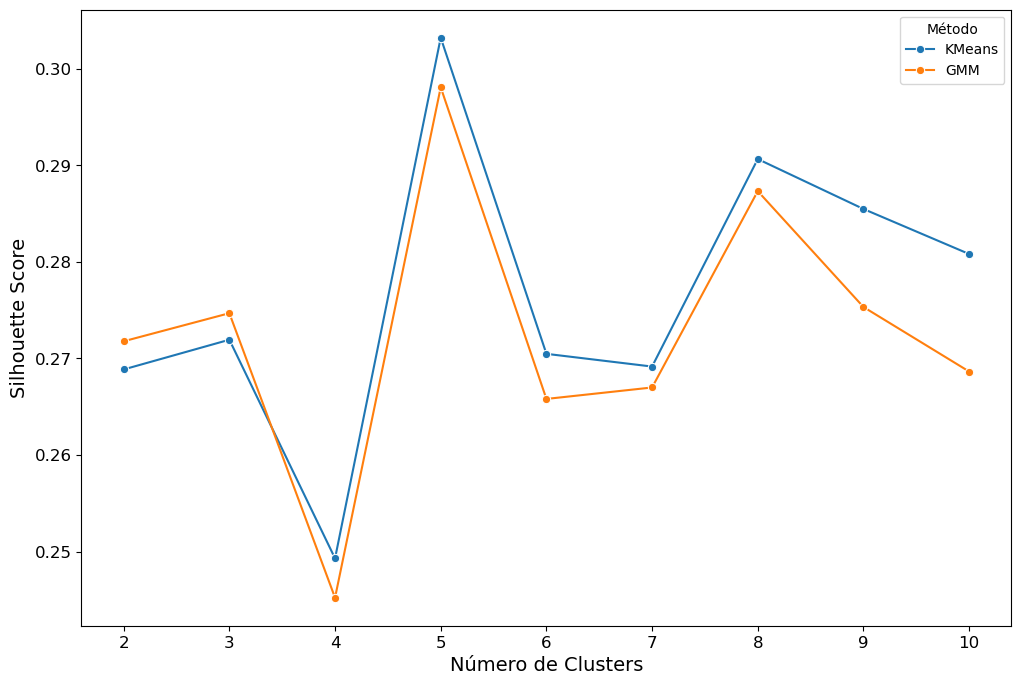

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dados para o gráfico
n_clusters_range = range(2, 11)  # De 2 a 10 clusters
kmeans_scores = [0.268864, 0.271941, 0.249301, 0.303211, 0.27048, 0.269163, 0.290649, 0.28548, 0.280816]
gmm_scores = [0.271781, 0.274688, 0.245228, 0.298076, 0.265811, 0.266997, 0.287327, 0.275330, 0.268648]

# Criar o DataFrame para o Seaborn
import pandas as pd
data = {
    'Número de Clusters': list(n_clusters_range) * 2,
    'Silhouette Score': kmeans_scores + gmm_scores,
    'Método': ['KMeans'] * len(kmeans_scores) + ['GMM'] * len(gmm_scores)
}
df = pd.DataFrame(data)

# Plotar os resultados
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='Número de Clusters', y='Silhouette Score', hue='Método', marker='o')

# Ajustar rótulos e título
plt.xlabel('Número de Clusters', fontsize=14)
plt.ylabel('Silhouette Score', fontsize=14)
plt.legend(title='Método')
plt.tick_params(axis='both', which='major', labelsize=12)

# Mostrar o gráfico
plt.show()


In [40]:
# final_metrics_df.to_csv("final_metrics.csv",index =False)

In [7]:
final_metrics_df = pd.read_csv("final_metrics.csv")

In [8]:
print(final_metrics_df.to_markdown())

|    |   k |   Silhouette Score |   Intra Cluster Distance |   Inter Cluster Distance |   Davies-Bouldin Index | Dataset         |
|---:|----:|-------------------:|-------------------------:|-------------------------:|-----------------------:|:----------------|
|  0 |   2 |           0.25396  |                 37.5401  |                 51.1463  |                1.57107 | MissForest_tSNE |
|  1 |   3 |           0.270605 |                 32.3523  |                 50.3444  |                1.21051 | MissForest_tSNE |
|  2 |   4 |           0.266935 |                 29.4353  |                 48.9645  |                1.17372 | MissForest_tSNE |
|  3 |   5 |           0.266885 |                 27.1674  |                 48.5515  |                1.14659 | MissForest_tSNE |
|  4 |   6 |           0.2855   |                 25.058   |                 48.1806  |                1.05963 | MissForest_tSNE |
|  5 |   7 |           0.268662 |                 23.9754  |                 47.697

##### Melhor resultado

In [22]:
results = worst_exams_24h_imputed_missforest

In [20]:
final_data_missforest_umap = pd.read_csv("../data/bases/final_data_missforest_umap.csv")

/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


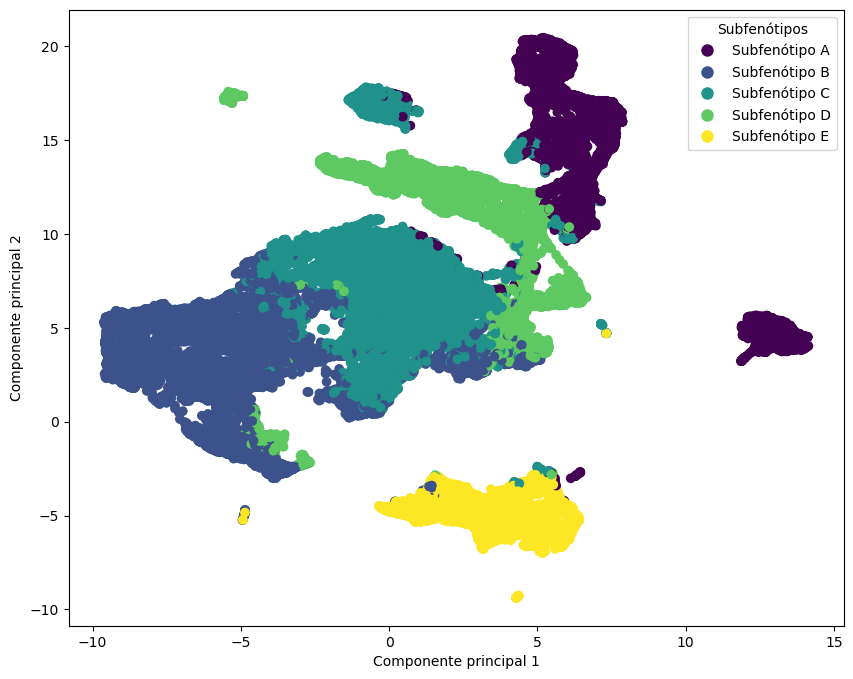

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.cluster import KMeans

# Supondo que `final_data_missforest_umap` seja seu DataFrame de dados
# Definição dos clusters e redução dimensional (já feito anteriormente)
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(final_data_missforest_umap)

# Adicionar a coluna de clusters ao DataFrame original
results['Cluster'] = clusters

# Reduzir a dimensionalidade para 2 componentes usando UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(final_data_missforest_umap)

# Converter os dados reduzidos para um DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Component_1', 'Component_2'])
reduced_df['Cluster'] = clusters

# Definir rótulos para os clusters
cluster_labels = {0: 'Subfenótipo A', 1: 'Subfenótipo B', 2: 'Subfenótipo C', 3: 'Subfenótipo D', 4: 'Subfenótipo E'}

# Mapear os números dos clusters para os rótulos
reduced_df['Cluster_Label'] = reduced_df['Cluster'].map(cluster_labels)

# Plotar os clusters
plt.figure(figsize=(10, 8))

# Plotar os pontos com cores diferentes para cada cluster
scatter = plt.scatter(
    reduced_df['Component_1'], 
    reduced_df['Component_2'], 
    c=reduced_df['Cluster'], 
    cmap='viridis', 
    marker='o'
)

# Adicionar uma legenda personalizada
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(c)), markersize=10, label=label) for c, label in cluster_labels.items()]
plt.legend(handles=handles, title='Subfenótipos')

# Adicionar labels e título
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')

# Exibir o gráfico
plt.show()


In [61]:
worst_exams_24h_imputed_missforest.to_csv("final_clusters.csv")

In [47]:
worst_exams_24h_imputed_missforest['Cluster'] = clusters

In [50]:
worst_exams_24h_imputed_missforest.columns

Index(['admission_type', 'marital_status', 'race', 'gender', 'ALT', 'Albumine',
       'Bilirubin', 'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Temperature',
       'WBC', 'Bicarbonate', 'Hemoglobin', 'sofa_24hours', 'gcs_min',
       'anchor_age', 'pao2fio2ratio_vent', 'platelet_min', 'Cluster'],
      dtype='object')

In [57]:
exams_columns = ['ALT', 'Albumine',
        'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Temperature',
       'WBC', 'Bicarbonate', 'Hemoglobin','gcs_min',
       'anchor_age']

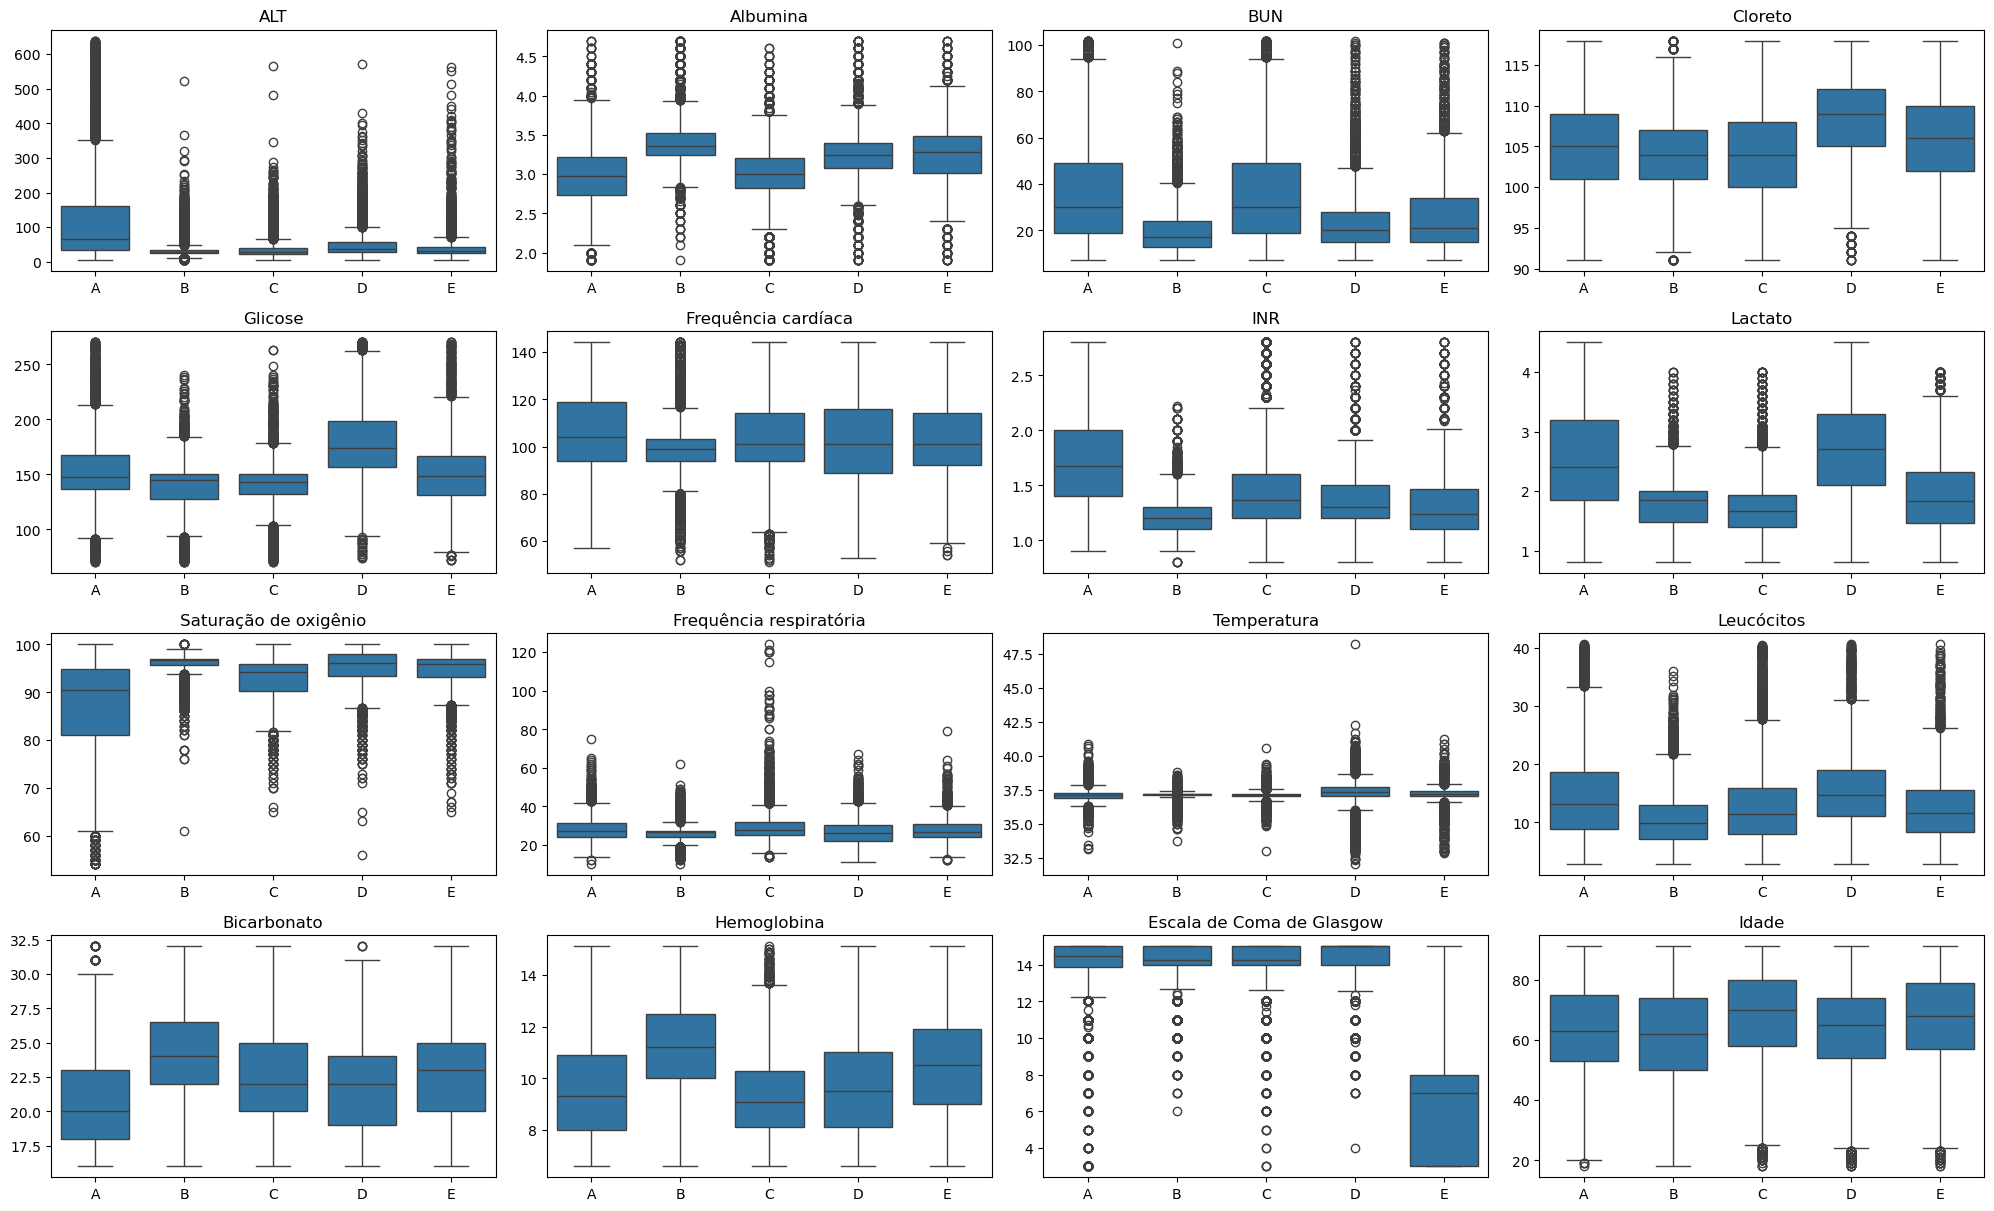

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dicionário de tradução dos nomes das colunas
translation_dict = {
    'ALT': 'ALT',
    'Albumine': 'Albumina',
    'gcs_min': 'Escala de Coma de Glasgow',
    'Bun': 'BUN',
    'Chloride': 'Cloreto',
    'Glucose': 'Glicose',
    'Heart_rate': 'Frequência cardíaca',
    'INR': 'INR',
    'Lactate': 'Lactato',
    'Oxygen_saturation': 'Saturação de oxigênio',
    'Respiratory_rate': 'Frequência respiratória',
    'Temperature': 'Temperatura',
    'WBC': 'Leucócitos',
    'Bicarbonate': 'Bicarbonato',
    'Hemoglobin': 'Hemoglobina',
    'anchor_age': 'Idade'
}

# Dicionário para substituir números por letras no eixo x
x_labels_dict = {i: chr(65 + i) for i in range(16)}

max_plots_per_figure = 16

# Função para plotar boxplots com largura proporcional
def plot_boxplots(df, columns, translation_dict, x_labels_dict, max_plots_per_figure):
    num_columns = len(columns)
    num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure  # Calcula o número de figuras necessárias
    
    for i in range(num_figures):
        plt.figure(figsize=(20, 15))
        start = i * max_plots_per_figure
        end = min(start + max_plots_per_figure, num_columns)
        
        for j, column in enumerate(columns[start:end]):
            plt.subplot((max_plots_per_figure // 4) + 1, 4, j + 1)
            
            # Transformar o DataFrame em formato longo
            df_long = df.melt(id_vars=['Cluster'], value_vars=[column], 
                              var_name='Exam', value_name='Value')
            
            # Calcular o número de amostras por cluster
            sample_counts = df_long.groupby('Cluster').size().reset_index(name='Count')
            
            # Merge as contagens com o DataFrame longo
            df_long = pd.merge(df_long, sample_counts, on='Cluster')
            
            # Calcular a largura das caixas com base na quantidade de dados
            df_long['Width'] = df_long['Count'] / df_long['Count'].max()
            
            # Plotar o box plot com largura proporcional
            sns.boxplot(x='Cluster', y='Value', data=df_long,
                        width=df_long['Width'].mean())  # Define a largura média para o box plot
            
            # Ajustar os rótulos do eixo x
            plt.xticks(ticks=range(len(df_long['Cluster'].unique())), 
                       labels=[x_labels_dict.get(i, i) for i in range(len(df_long['Cluster'].unique()))])
            
            plt.title(translation_dict.get(column, column))
            plt.xlabel('')
            plt.ylabel('')
        
        plt.tight_layout()
        plt.show()

# Definição das colunas de exames

# Plotar os boxplots
plot_boxplots(worst_exams_24h_imputed_missforest, exams_columns, translation_dict, x_labels_dict, max_plots_per_figure)


<Figure size 1200x600 with 0 Axes>

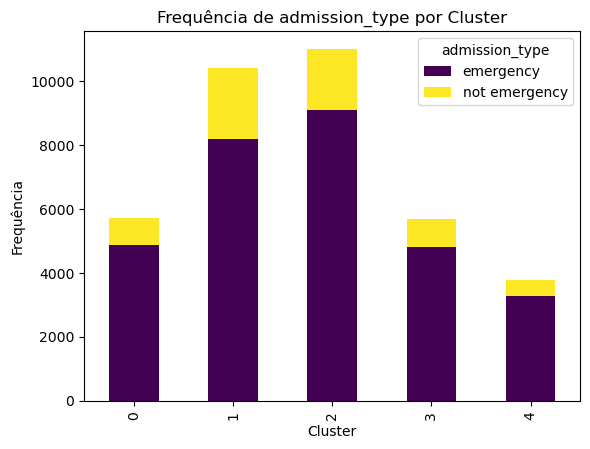

<Figure size 1200x600 with 0 Axes>

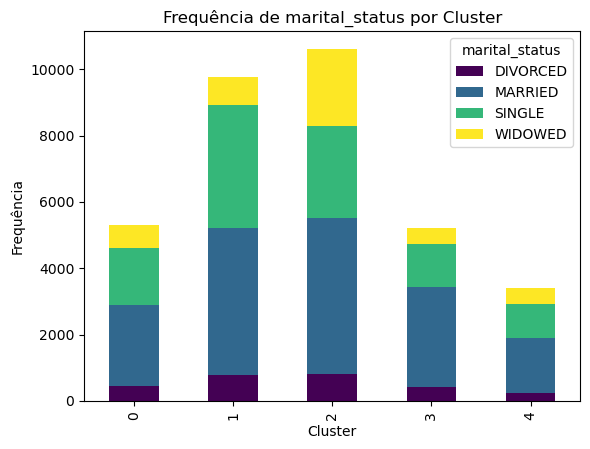

<Figure size 1200x600 with 0 Axes>

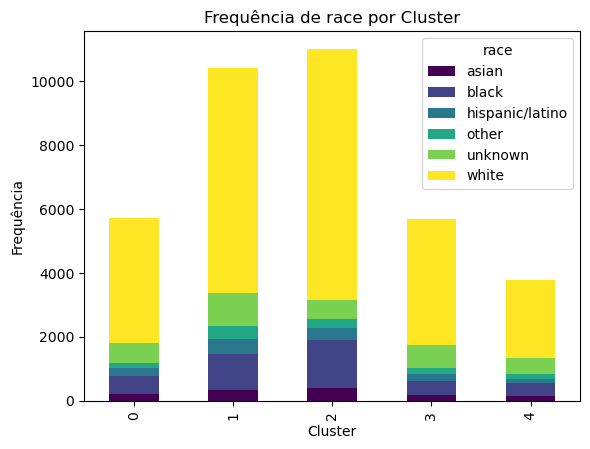

<Figure size 1200x600 with 0 Axes>

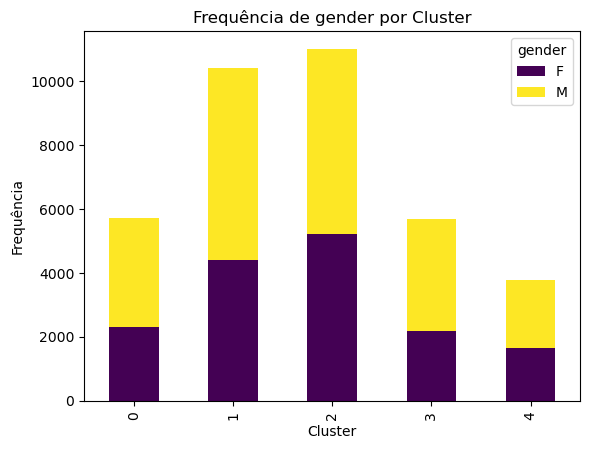

In [58]:
# Definir as colunas categóricas
categorical_columns = ['admission_type', 'marital_status', 'race', 'gender']

# Função para calcular a frequência das categorias para cada cluster
def calculate_frequency(df, categorical_columns):
    frequency_dfs = {}
    for column in categorical_columns:
        freq_df = df.groupby(['Cluster', column]).size().unstack(fill_value=0)
        frequency_dfs[column] = freq_df
    return frequency_dfs

# Calcular a frequência das categorias
frequency_dfs = calculate_frequency(worst_exams_24h_imputed_missforest, categorical_columns)

# Plotar as frequências
def plot_frequencies(frequency_dfs):
    for column, freq_df in frequency_dfs.items():
        plt.figure(figsize=(12, 6))
        freq_df.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'Frequência de {column} por Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Frequência')
        plt.legend(title=column)
        plt.show()

# Plotar as frequências
plot_frequencies(frequency_dfs)

#### GMM

In [6]:
final_data_missforest_tsne =  pd.read_csv("final_data_missforest_tsne.csv")
final_data_knn_tsne = pd.read_csv("final_data_knn_tsne.csv")
final_data_missforest_umap =  pd.read_csv("final_data_missforest_umap.csv")
final_data_knn_umap =  pd.read_csv("final_data_knn_umap.csv")

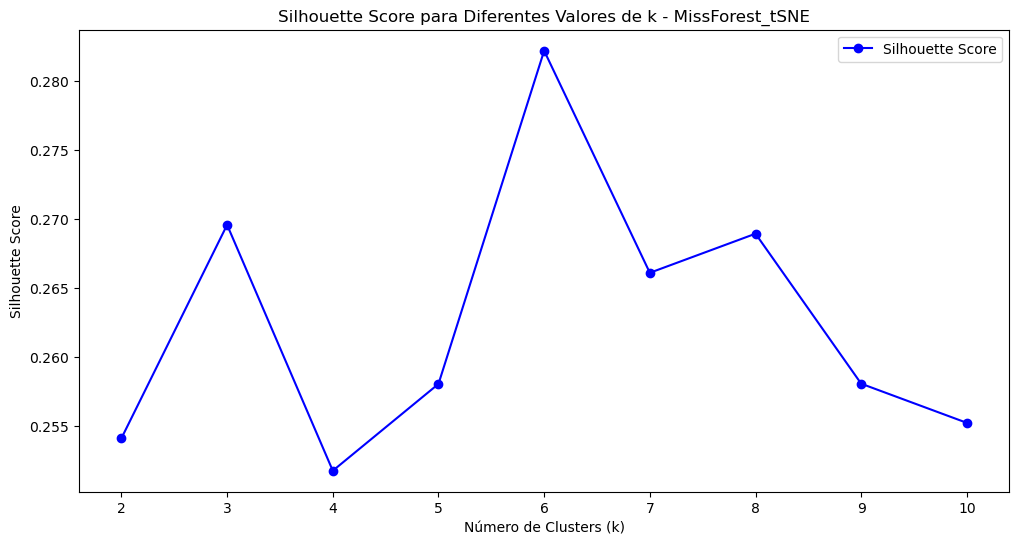

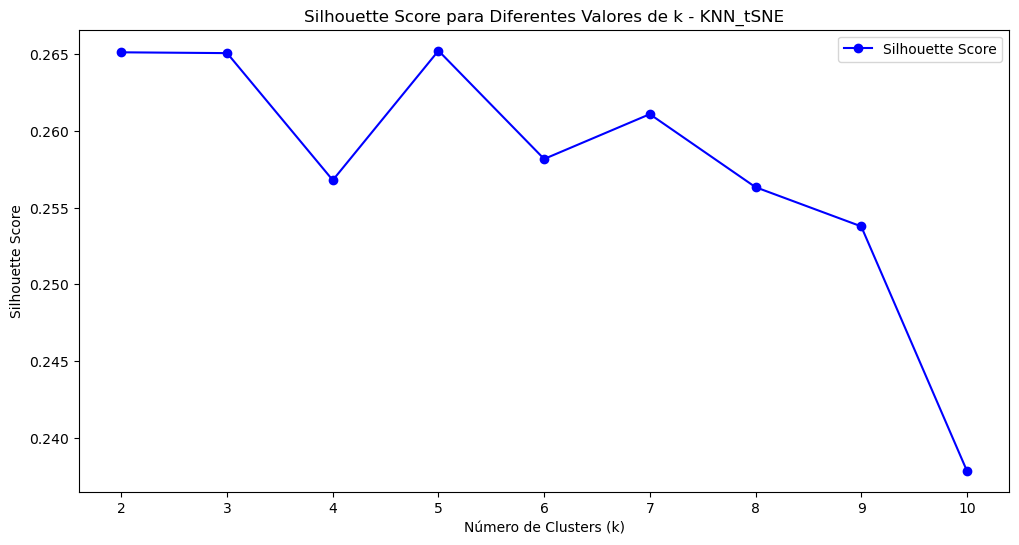

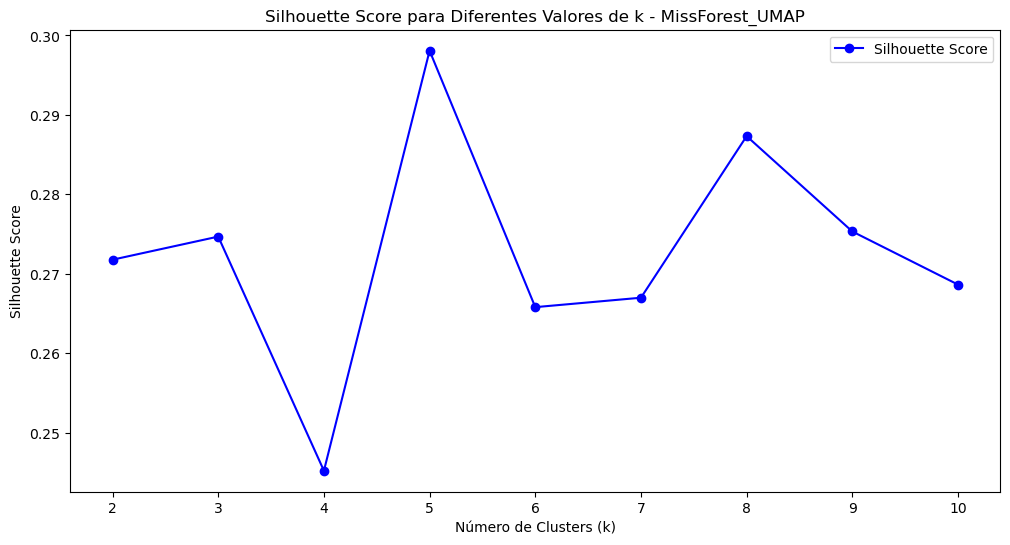

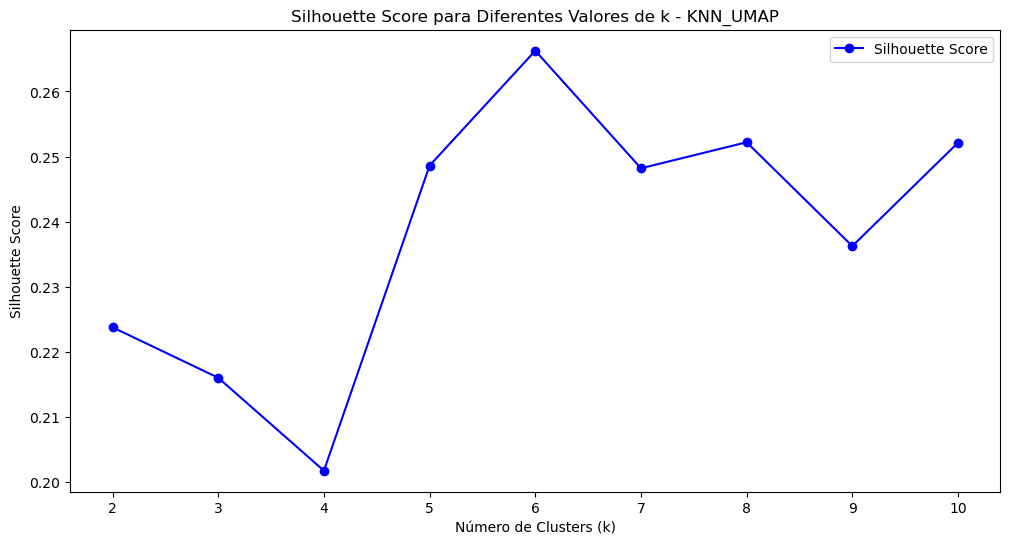

,k,Silhouette Score,Intra Cluster Distance,Inter Cluster Distance,Davies-Bouldin Index,Dataset
0,2,0.254079,37.542209,51.163385,1.570218,MissForest_tSNE
1,3,0.269573,32.231794,50.420217,1.219011,MissForest_tSNE
2,4,0.251721,28.807233,48.593334,1.148909,MissForest_tSNE
3,5,0.258023,26.691808,48.493364,1.150287,MissForest_tSNE
4,6,0.282217,24.946533,48.259920,1.053024,MissForest_tSNE
5,7,0.266092,23.888323,47.677409,1.102568,MissForest_tSNE
6,8,0.268931,22.285380,47.570978,1.027450,MissForest_tSNE
7,9,0.258039,21.505449,47.343208,1.034576,MissForest_tSNE
8,10,0.255197,20.852854,47.002951,1.065283,MissForest_tSNE
9,2,0.265126,42.378426,58.924095,1.487609,KNN_tSNE


In [16]:
# Lista de DataFrames e seus prefixos
dfs = [
    (final_data_missforest_tsne, "MissForest_tSNE"),
    (final_data_knn_tsne, "KNN_tSNE"),
    (final_data_missforest_umap, "MissForest_UMAP"),
    (final_data_knn_umap, "KNN_UMAP")
]

# Armazenar todos os DataFrames de métricas em uma lista
all_metrics_dfs = []

for df, name_prefix in dfs:
    metrics_df = generate_gmm_metrics(df, name_prefix)
    all_metrics_dfs.append(metrics_df)

# Concatenar todos os DataFrames de métricas em um único DataFrame
final_metrics_df = pd.concat(all_metrics_dfs, ignore_index=True)


final_metrics_df

In [12]:

def evaluate_gmm_parameters(df, name_prefix):
    # Definindo os parâmetros a serem avaliados
    param_grid = {
        'n_components': range(2, 11),  # Testando de 2 a 10 componentes
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Diferentes tipos de covariância
        'init_params': ['kmeans', 'random'],  # Métodos de inicialização
    }
    
    # Armazenar os resultados
    results = {
        'n_components': [],
        'covariance_type': [],
        'init_params': [],
        'Silhouette Score': [],
        'BIC': []
    }

    # Avaliação dos parâmetros
    for n_components in param_grid['n_components']:
        for covariance_type in param_grid['covariance_type']:
            for init_params in param_grid['init_params']:
                gmm = GaussianMixture(
                    n_components=n_components,
                    covariance_type=covariance_type,
                    init_params=init_params,
                    random_state=42
                )
                gmm.fit(df)
                labels = gmm.predict(df)
                
                # Calcular o Silhouette Score
                if len(np.unique(labels)) > 1:  # Silhouette Score requer pelo menos 2 clusters distintos
                    silhouette = silhouette_score(df, labels)
                else:
                    silhouette = np.nan
                
                # Calcular o BIC
                bic = gmm.bic(df)
                
                # Armazenar os resultados
                results['n_components'].append(n_components)
                results['covariance_type'].append(covariance_type)
                results['init_params'].append(init_params)
                results['Silhouette Score'].append(silhouette)
                results['BIC'].append(bic)
    
    # Criar DataFrame com os resultados
    results_df = pd.DataFrame(results)
    results_df['Dataset'] = name_prefix
    
    # Exibir os melhores parâmetros com base no Silhouette Score
    best_silhouette = results_df.loc[results_df['Silhouette Score'].idxmax()]
    print("Melhores parâmetros com base no Silhouette Score:")
    print(best_silhouette)
    
    # Exibir os melhores parâmetros com base no BIC
    best_bic = results_df.loc[results_df['BIC'].idxmin()]
    print("\nMelhores parâmetros com base no BIC:")
    print(best_bic)
    
    # Plot do Silhouette Score para diferentes combinações de parâmetros
    plt.figure(figsize=(12, 6))
    plt.plot(results['n_components'], results['Silhouette Score'], 'o-', label='Silhouette Score', color='blue')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Score para Diferentes Parâmetros - {name_prefix}')
    plt.legend()
    plt.show()
    
    return results_df

Melhores parâmetros com base no Silhouette Score:
n_components                      5
covariance_type           spherical
init_params                  kmeans
Silhouette Score           0.298076
BIC                   451510.233548
Dataset             MissForest_UMAP
Name: 30, dtype: object

Melhores parâmetros com base no BIC:
n_components                     10
covariance_type                full
init_params                  kmeans
Silhouette Score           0.228322
BIC                   296262.984005
Dataset             MissForest_UMAP
Name: 64, dtype: object


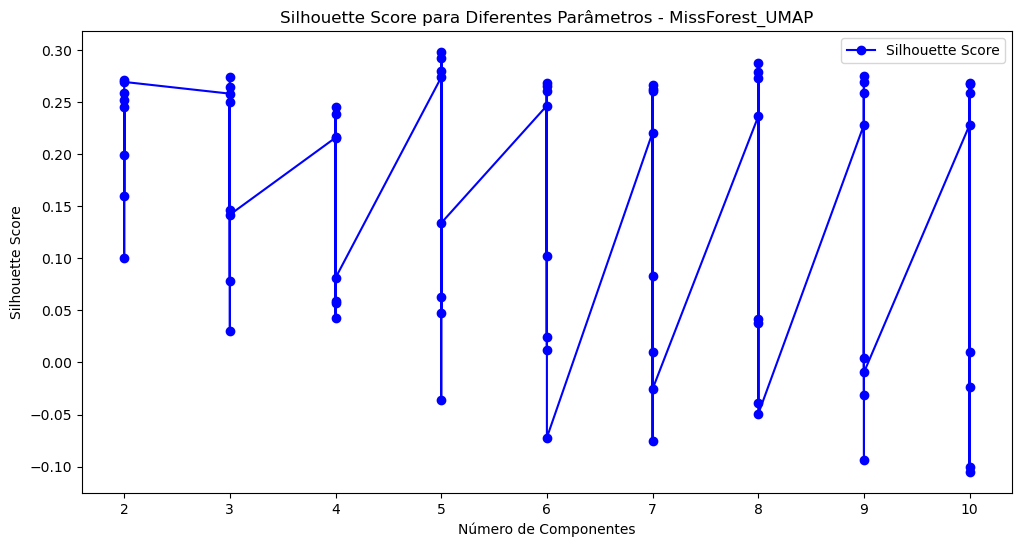

In [13]:
gmm_results = evaluate_gmm_parameters(final_data_missforest_umap, "MissForest_UMAP")

Melhores parâmetros com base no Silhouette Score:
n_components                    6
covariance_type         spherical
init_params                kmeans
Silhouette Score         0.266264
BIC                 423841.205332
Dataset                  knn_UMAP
Name: 38, dtype: object

Melhores parâmetros com base no BIC:
n_components                   10
covariance_type              full
init_params                kmeans
Silhouette Score            0.223
BIC                 236412.245575
Dataset                  knn_UMAP
Name: 64, dtype: object


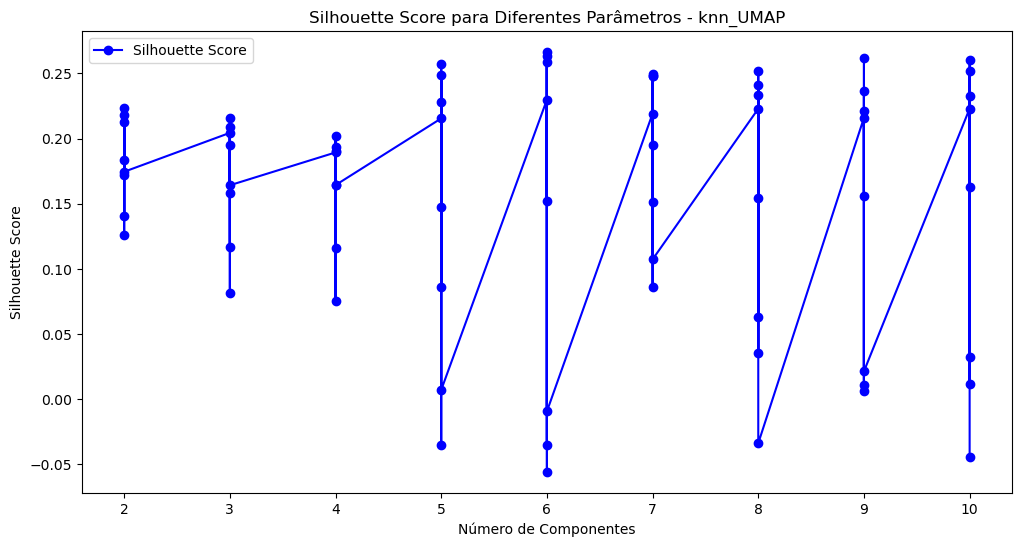

In [14]:
gmm_results = evaluate_gmm_parameters(final_data_knn_umap, "knn_UMAP")

##### Melhor resultado

In [37]:
results = pd.read_csv("../data/bases/final_data_missforest_umap.csv")

In [38]:
final_data_missforest_umap = pd.read_csv("../data/bases/final_data_missforest_umap.csv")

/home/grad/ccomp/21/giovana.assis/miniconda3/envs/myenv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


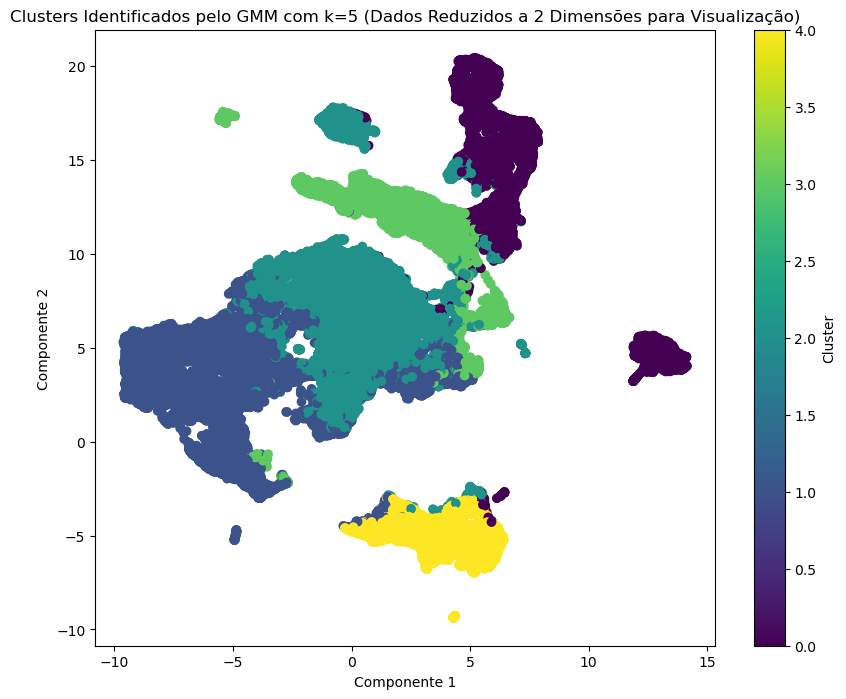

In [39]:
gmm = GaussianMixture(n_components=5, random_state=42,covariance_type='spherical')
gmm.fit(final_data_missforest_umap)
clusters_gmm = gmm.predict(final_data_missforest_umap)
# Adicionar a coluna de clusters ao DataFrame original
results['Cluster'] = clusters_gmm

# Reduzir a dimensionalidade para 2 componentes usando UMAP para visualização
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_data = umap_reducer.fit_transform(final_data_missforest_umap)

# Converter os dados reduzidos para um DataFrame
reduced_df = pd.DataFrame(reduced_data, columns=['Component_1', 'Component_2'])
reduced_df['Cluster'] = clusters_gmm

# Plotar os clusters
plt.figure(figsize=(10, 8))

# Plotar os pontos com cores diferentes para cada cluster
scatter = plt.scatter(
    reduced_df['Component_1'], 
    reduced_df['Component_2'], 
    c=reduced_df['Cluster'], 
    cmap='viridis', 
    marker='o'
)

# Adicionar uma barra de cores
plt.colorbar(scatter, label='Cluster')

# Adicionar labels e título
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.title('Clusters Identificados pelo GMM com k=5 (Dados Reduzidos a 2 Dimensões para Visualização)')

# Exibir o gráfico
plt.show()

In [40]:
worst_exams_24h_imputed_missforest['Cluster'] = clusters_gmm

In [41]:
exams_columns = ['ALT', 'Albumine',
       'Bilirubin', 'Bun', 'Chloride', 'Glucose', 'Heart_rate', 'INR',
       'Lactate', 'Oxygen_saturation', 'Respiratory_rate', 'Temperature',
       'WBC', 'Bicarbonate', 'Hemoglobin', 'sofa_24hours', 'gcs_min',
       'anchor_age', 'pao2fio2ratio_vent', 'platelet_min']

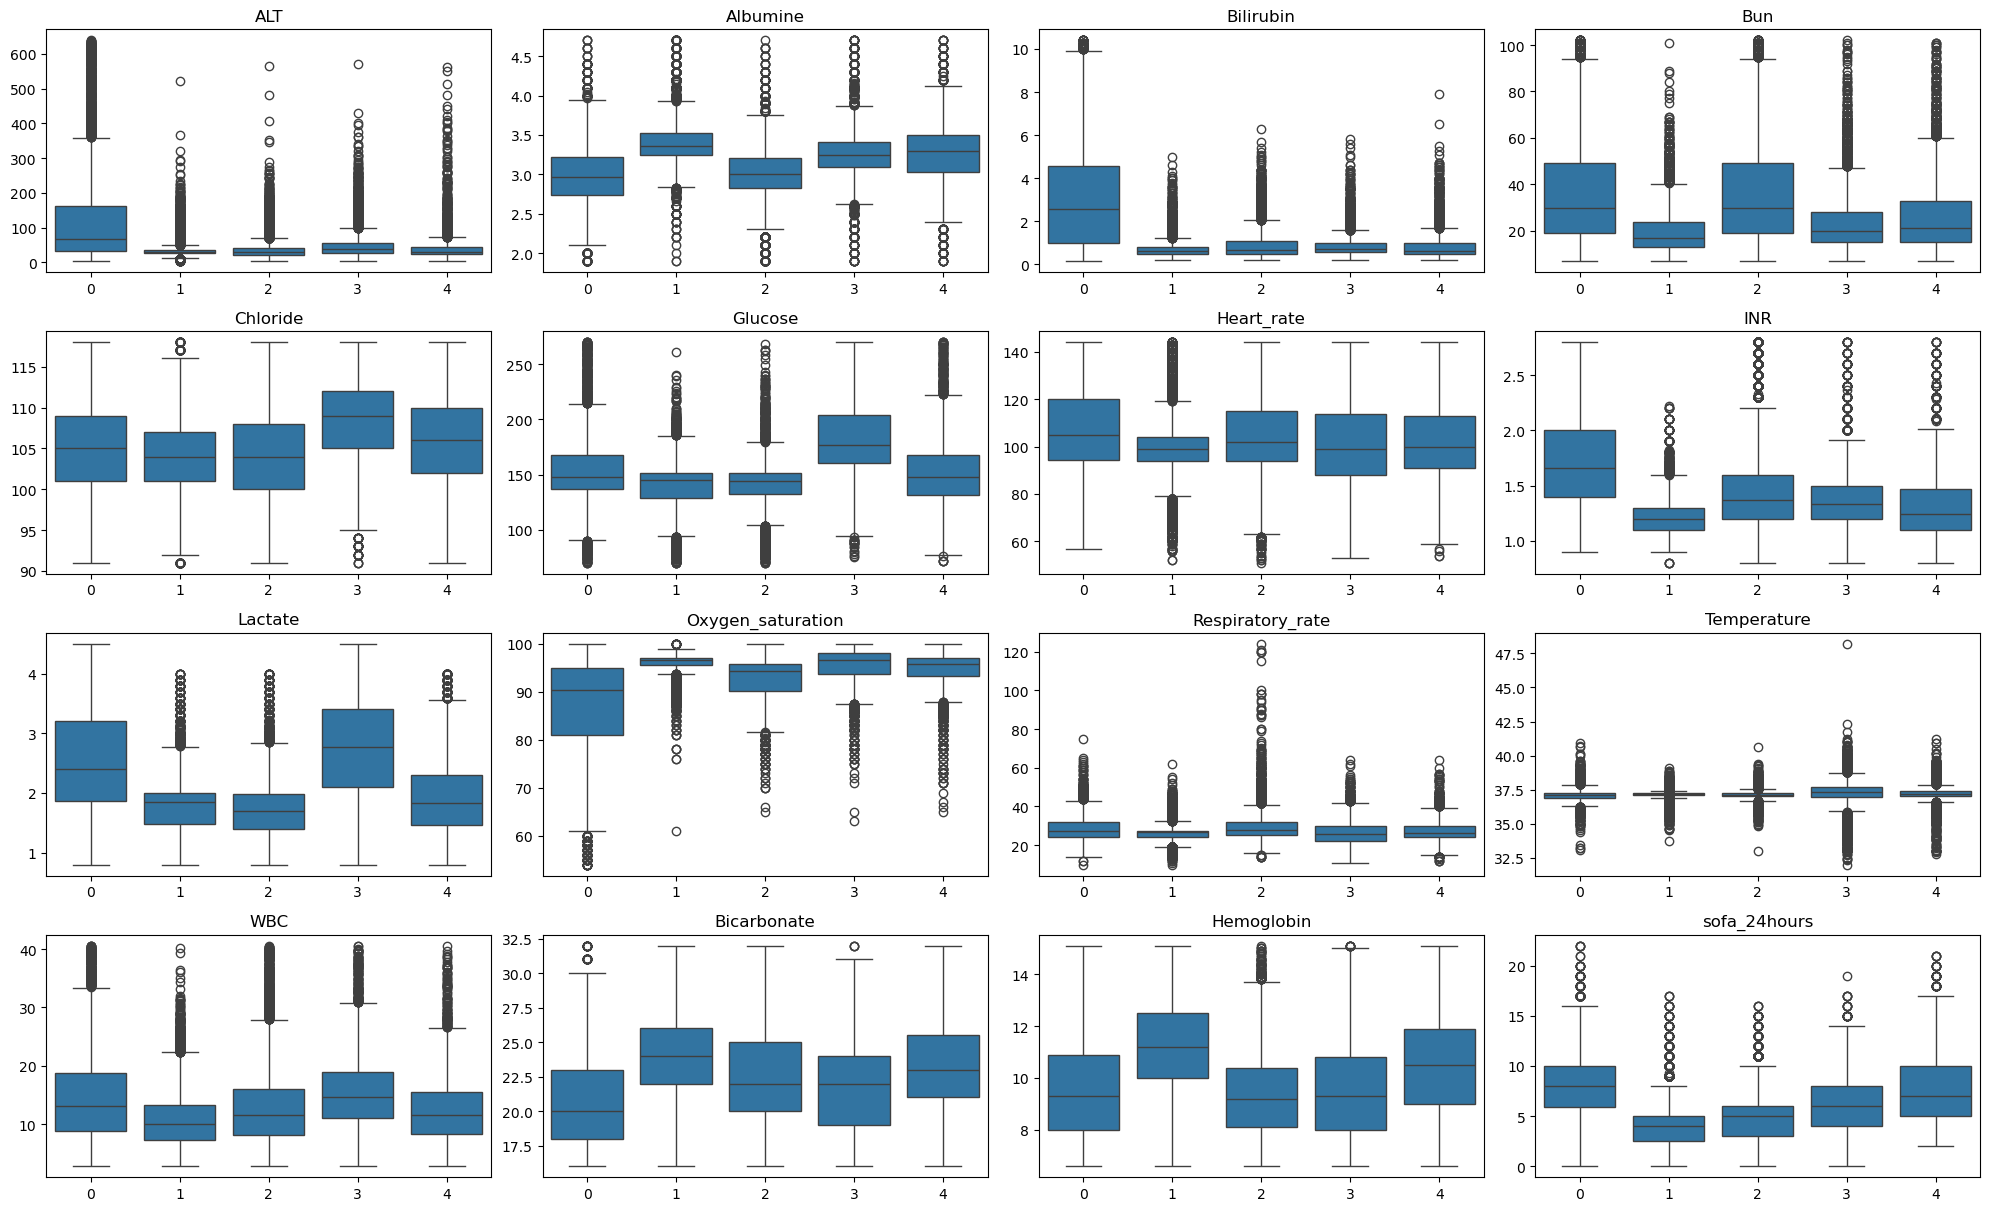

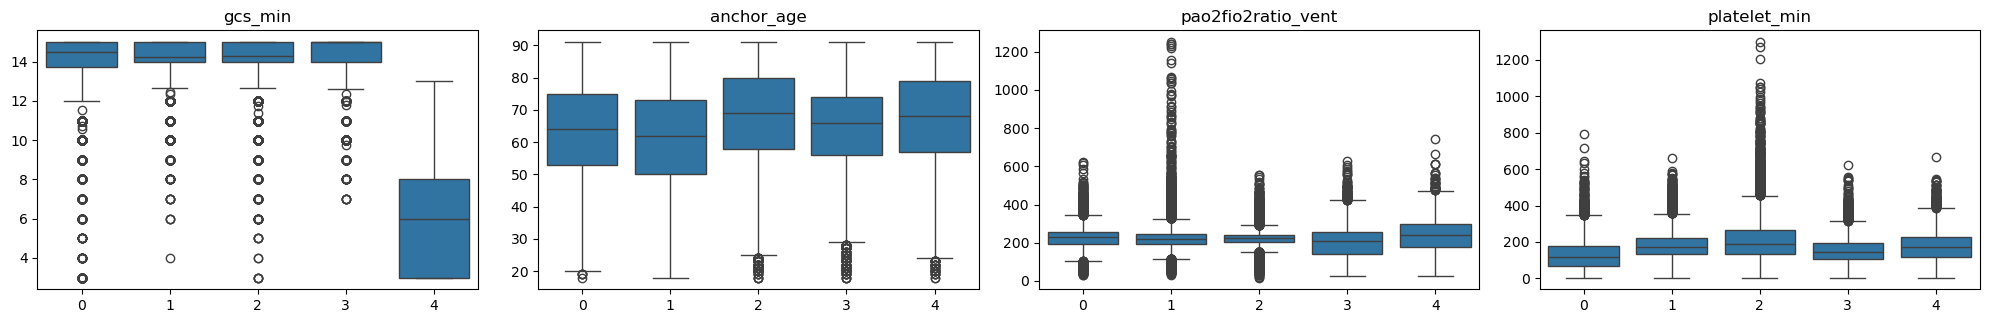

In [42]:
max_plots_per_figure = 16

# Função para plotar boxplots
def plot_boxplots(df, columns, max_plots_per_figure):
    num_columns = len(columns)
    num_figures = (num_columns + max_plots_per_figure - 1) // max_plots_per_figure  # Calcula o número de figuras necessárias
    
    for i in range(num_figures):
        plt.figure(figsize=(20, 15))
        start = i * max_plots_per_figure
        end = min(start + max_plots_per_figure, num_columns)
        
        for j, column in enumerate(columns[start:end]):
            plt.subplot((max_plots_per_figure // 4) + 1, 4, j + 1)
            sns.boxplot(x='Cluster', y=column, data=df)
            plt.title(column)
            plt.xlabel('')
            plt.ylabel('')
        
        plt.tight_layout()
        plt.show()

# Plotar os boxplots
plot_boxplots(worst_exams_24h_imputed_missforest, exams_columns, max_plots_per_figure)

<Figure size 1200x600 with 0 Axes>

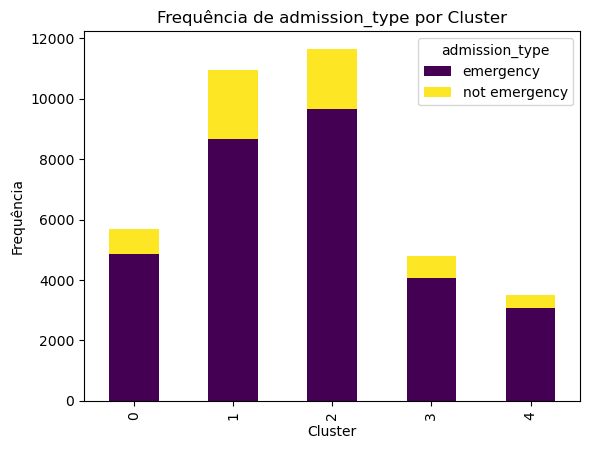

<Figure size 1200x600 with 0 Axes>

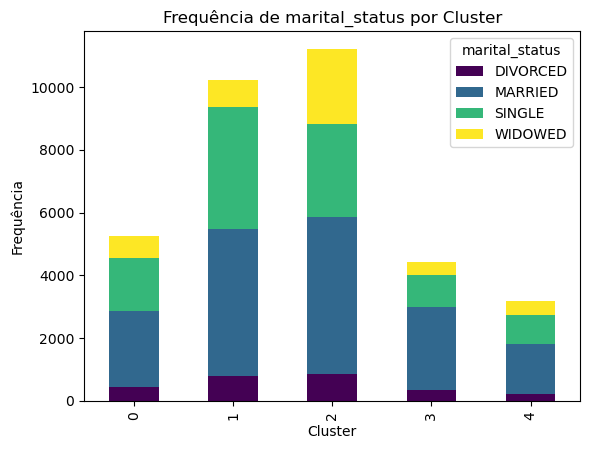

<Figure size 1200x600 with 0 Axes>

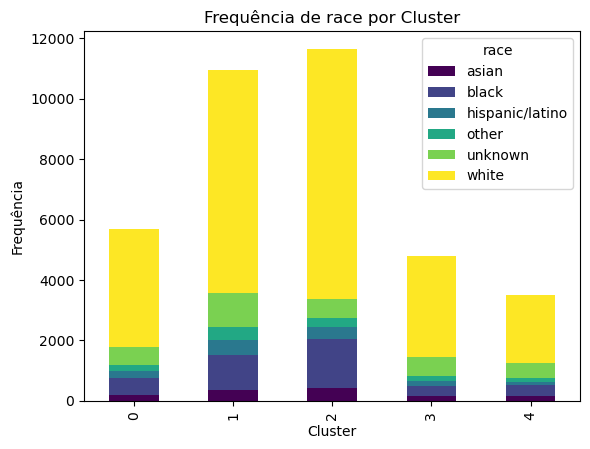

<Figure size 1200x600 with 0 Axes>

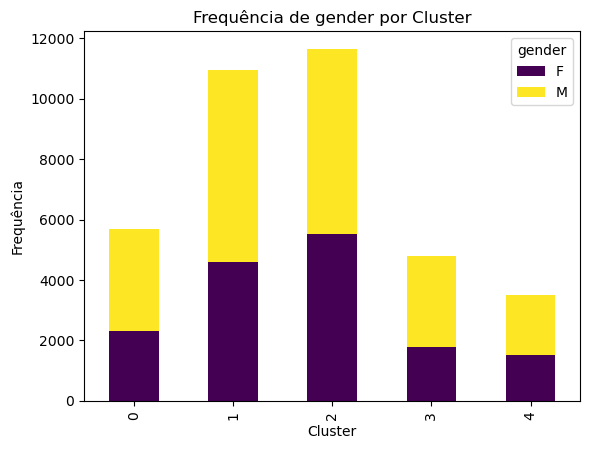

In [27]:
# Definir as colunas categóricas
categorical_columns = ['admission_type', 'marital_status', 'race', 'gender']

# Função para calcular a frequência das categorias para cada cluster
def calculate_frequency(df, categorical_columns):
    frequency_dfs = {}
    for column in categorical_columns:
        freq_df = df.groupby(['Cluster', column]).size().unstack(fill_value=0)
        frequency_dfs[column] = freq_df
    return frequency_dfs

# Calcular a frequência das categorias
frequency_dfs = calculate_frequency(worst_exams_24h_imputed_missforest, categorical_columns)

# Plotar as frequências
def plot_frequencies(frequency_dfs):
    for column, freq_df in frequency_dfs.items():
        plt.figure(figsize=(12, 6))
        freq_df.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'Frequência de {column} por Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Frequência')
        plt.legend(title=column)
        plt.show()

# Plotar as frequências
plot_frequencies(frequency_dfs)